In [6]:
# Check what columns exist
print("All columns in dataset:")
print(df.columns.tolist())

All columns in dataset:
['Date', 'stock', 'daily_return', 'r_1W', 'r_1M', 'r_3M', 'vol_1M', 'MA20_ratio', 'MA50_ratio', 'HL_range', 'vol_z', 'sp500_daily_return', 'sp500_vol_1M', 'relative_return', 'volatility_ratio', 'VIX_t', 'FedFunds_t', 'CPI_chg', 'FedFunds_chg', 'Put_Call_Ratio_t', 'Market_Breadth_t', 'spy_RSI_t', 'spy_SMA_50_t', 'spy_SMA_200_t', 'qqq_RSI_t', 'qqq_SMA_50_t', 'qqq_SMA_200_t', 'sector_XLK_t', 'sector_XLF_t', 'sector_XLV_t', 'sector_XLE_t', 'sector_XLI_t', 'y']


## Load and Inspect the ML-Ready Dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Set style for nice plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("STEP 1: Loading ML-Ready Dataset")
print("="*60)

# Load the dataset (using the renamed file)
df = pd.read_csv('ml_ready_dataset.csv')  # ← Updated filename

print(f"\n✓ Dataset loaded successfully")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")
print(f"  Date range: {df['Date'].min()} to {df['Date'].max()}")

# Display basic info
print(f"\n✓ Stocks in dataset:")
print(df['stock'].value_counts())

print(f"\n✓ Target variable distribution:")
print(df['y'].value_counts())  # ← Using 'y' as target
print("\nClass balance:")
print(df['y'].value_counts(normalize=True))

# Check for missing values
print(f"\n✓ Missing values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("  No missing values ✓")
else:
    print(missing[missing > 0])

# Display first few rows
print(f"\n✓ First 5 rows:")
print(df.head())

STEP 1: Loading ML-Ready Dataset

✓ Dataset loaded successfully
  Shape: (8594, 33)
  Columns: 33
  Date range: 2004-11-17 to 2025-10-31

✓ Stocks in dataset:
stock
GOOGL    5273
META     3321
Name: count, dtype: int64

✓ Target variable distribution:
y
1    4839
0    3755
Name: count, dtype: int64

Class balance:
y
1    0.563067
0    0.436933
Name: proportion, dtype: float64

✓ Missing values:
  No missing values ✓

✓ First 5 rows:
         Date  stock  daily_return      r_1W      r_1M      r_3M    vol_1M  \
0  2004-11-17  GOOGL     -0.000232  0.027642  0.166013  0.719155  0.055914   
1  2004-11-18  GOOGL     -0.028754 -0.084581  0.192541  0.546857  0.054962   
2  2004-11-19  GOOGL      0.011102 -0.069231  0.134021  0.548446  0.053586   
3  2004-11-22  GOOGL     -0.025384 -0.106940 -0.042510  0.574330  0.042047   
4  2004-11-23  GOOGL      0.014658 -0.029095 -0.106083  0.580377  0.037156   

   MA20_ratio  MA50_ratio  HL_range  ...  spy_SMA_200_t  qqq_RSI_t  \
0    0.957913    1.16073

## Prepare Features and Target for Training

In [8]:
print("\n" + "="*60)
print("STEP 2: Preparing Features and Target")
print("="*60)

# Identify columns to exclude from features
exclude_cols = [
    'Date',      # Not a feature (time index)
    'stock',     # Not a feature (categorical identifier)
    'y'          # ← Changed from 'target' to 'y' - This is what we're predicting
]

# Remove columns that might not exist
exclude_cols = [col for col in exclude_cols if col in df.columns]

# Create feature matrix (X) and target vector (y)
X = df.drop(columns=exclude_cols)
y = df['y']  # ← Changed from df['target'] to df['y']

print(f"\n✓ Feature matrix (X) shape: {X.shape}")
print(f"✓ Target vector (y) shape: {y.shape}")

print(f"\n✓ Features being used ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\n⚠️  Warning: Non-numeric columns found: {non_numeric}")
    print("   Dropping these columns...")
    X = X.select_dtypes(include=[np.number])
    print(f"   New shape: {X.shape}")


STEP 2: Preparing Features and Target

✓ Feature matrix (X) shape: (8594, 30)
✓ Target vector (y) shape: (8594,)

✓ Features being used (30):
   1. daily_return
   2. r_1W
   3. r_1M
   4. r_3M
   5. vol_1M
   6. MA20_ratio
   7. MA50_ratio
   8. HL_range
   9. vol_z
  10. sp500_daily_return
  11. sp500_vol_1M
  12. relative_return
  13. volatility_ratio
  14. VIX_t
  15. FedFunds_t
  16. CPI_chg
  17. FedFunds_chg
  18. Put_Call_Ratio_t
  19. Market_Breadth_t
  20. spy_RSI_t
  21. spy_SMA_50_t
  22. spy_SMA_200_t
  23. qqq_RSI_t
  24. qqq_SMA_50_t
  25. qqq_SMA_200_t
  26. sector_XLK_t
  27. sector_XLF_t
  28. sector_XLV_t
  29. sector_XLE_t
  30. sector_XLI_t


## Chronological Train-Test Split

In [9]:
print("\n" + "="*60)
print("STEP 3: Chronological Train-Test Split (80/20)")
print("="*60)

# Important: Use shuffle=False for time-series data!
# This ensures older data = training, newer data = testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    shuffle=False,      # CRITICAL: Maintain temporal order
    random_state=42
)

print(f"\n✓ Training set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Class distribution: {y_train.value_counts().to_dict()}")

print(f"\n✓ Test set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Class distribution: {y_test.value_counts().to_dict()}")

# Verify chronological split (if Date column exists in original df)
if 'Date' in df.columns:
    dates = df['Date']
    train_dates = dates.iloc[:len(X_train)]
    test_dates = dates.iloc[len(X_train):]

    print(f"\n✓ Temporal split verification:")
    print(f"  Train period: {train_dates.min()} to {train_dates.max()}")
    print(f"  Test period:  {test_dates.min()} to {test_dates.max()}")


STEP 3: Chronological Train-Test Split (80/20)

✓ Training set:
  X_train shape: (6875, 30)
  y_train shape: (6875,)
  Class distribution: {1: 3888, 0: 2987}

✓ Test set:
  X_test shape: (1719, 30)
  y_test shape: (1719,)
  Class distribution: {1: 951, 0: 768}

✓ Temporal split verification:
  Train period: 2004-11-17 to 2025-10-31
  Test period:  2019-01-02 to 2025-10-31


## Train Logistic Regression Model

In [10]:
print("\n" + "="*60)
print("STEP 4: Training Logistic Regression Model")
print("="*60)

# Initialize Logistic Regression
# Using L2 regularization (default) with moderate C value
logistic_model = LogisticRegression(
    C=1.0,                    # Regularization strength (lower = stronger)
    max_iter=1000,            # Maximum iterations for convergence
    solver='lbfgs',           # Optimization algorithm
    random_state=42,          # For reproducibility
    class_weight='balanced'   # Handle class imbalance automatically
)

print("\n✓ Model configuration:")
print(f"  Algorithm: Logistic Regression")
print(f"  Regularization: L2 (Ridge)")
print(f"  C parameter: {logistic_model.C}")
print(f"  Class weighting: Balanced")

# Train the model
print("\n✓ Training model...")
import time
start_time = time.time()

logistic_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Make predictions
print("\n✓ Generating predictions...")
y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

# Get prediction probabilities (for ROC curve)
y_train_proba = logistic_model.predict_proba(X_train)[:, 1]
y_test_proba = logistic_model.predict_proba(X_test)[:, 1]

print("✓ Predictions generated for train and test sets")


STEP 4: Training Logistic Regression Model

✓ Model configuration:
  Algorithm: Logistic Regression
  Regularization: L2 (Ridge)
  C parameter: 1.0
  Class weighting: Balanced

✓ Training model...
✓ Training completed in 4.77 seconds

✓ Generating predictions...
✓ Predictions generated for train and test sets


## Evaluate Model Performance

In [11]:
print("\n" + "="*60)
print("STEP 5: Model Performance Evaluation")
print("="*60)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Display results
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

print("\n📊 TRAINING SET PERFORMANCE:")
print(f"  Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")
print(f"  ROC-AUC:   {train_auc:.4f}")

print("\n📊 TEST SET PERFORMANCE:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_auc:.4f}")

# Check for overfitting
accuracy_diff = train_accuracy - test_accuracy
print("\n📈 OVERFITTING CHECK:")
print(f"  Train-Test Accuracy Gap: {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
if accuracy_diff < 0.05:
    print("  ✓ Model generalizes well (low overfitting)")
elif accuracy_diff < 0.10:
    print("  ⚠️  Moderate overfitting detected")
else:
    print("  ❌ High overfitting - model may be memorizing training data")

# Detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(y_test, y_test_pred,
                          target_names=['Underperform (0)', 'Outperform (1)']))


STEP 5: Model Performance Evaluation

PERFORMANCE METRICS

📊 TRAINING SET PERFORMANCE:
  Accuracy:  0.5495 (54.95%)
  Precision: 0.6141
  Recall:    0.5473
  F1-Score:  0.5788
  ROC-AUC:   0.5698

📊 TEST SET PERFORMANCE:
  Accuracy:  0.5125 (51.25%)
  Precision: 0.5806
  Recall:    0.4280
  F1-Score:  0.4927
  ROC-AUC:   0.5768

📈 OVERFITTING CHECK:
  Train-Test Accuracy Gap: 0.0370 (3.70%)
  ✓ Model generalizes well (low overfitting)

DETAILED CLASSIFICATION REPORT (TEST SET)
                  precision    recall  f1-score   support

Underperform (0)       0.47      0.62      0.53       768
  Outperform (1)       0.58      0.43      0.49       951

        accuracy                           0.51      1719
       macro avg       0.52      0.52      0.51      1719
    weighted avg       0.53      0.51      0.51      1719



## Confusion Matrix Visualization


STEP 6: Confusion Matrix Visualization


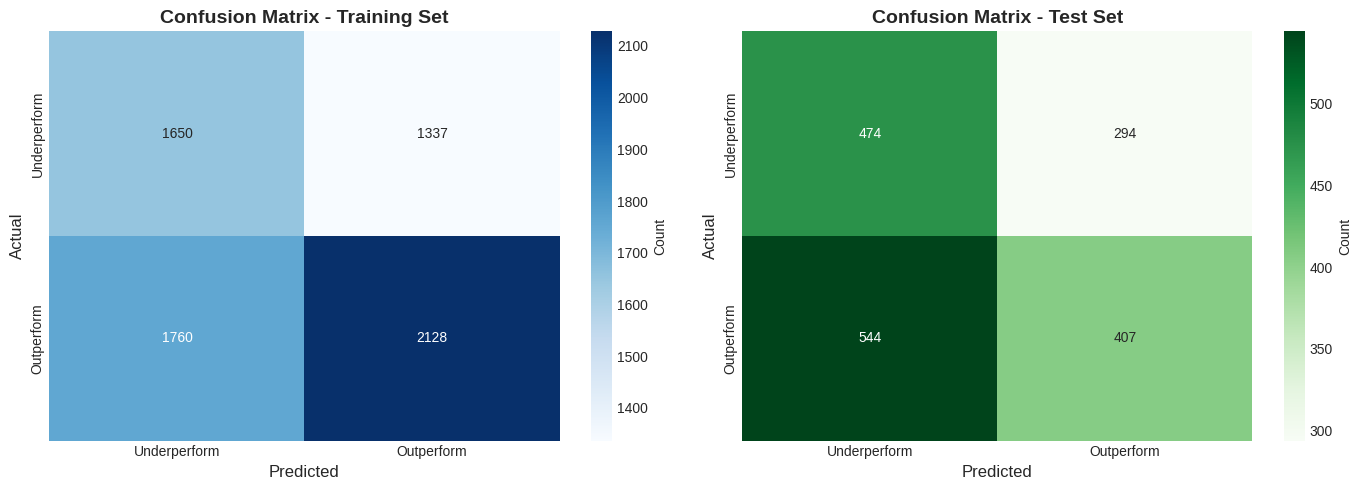

✓ Confusion matrices saved as 'confusion_matrices.png'

📊 CONFUSION MATRIX INTERPRETATION:
  True Negatives (TN):  474 - Correctly predicted underperform
  False Positives (FP): 294 - Wrongly predicted outperform
  False Negatives (FN): 544 - Wrongly predicted underperform
  True Positives (TP):  407 - Correctly predicted outperform


In [12]:
print("\n" + "="*60)
print("STEP 6: Confusion Matrix Visualization")
print("="*60)

# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Underperform', 'Outperform'],
            yticklabels=['Underperform', 'Outperform'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Underperform', 'Outperform'],
            yticklabels=['Underperform', 'Outperform'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved as 'confusion_matrices.png'")

# Explain confusion matrix
print("\n📊 CONFUSION MATRIX INTERPRETATION:")
print(f"  True Negatives (TN):  {cm_test[0,0]} - Correctly predicted underperform")
print(f"  False Positives (FP): {cm_test[0,1]} - Wrongly predicted outperform")
print(f"  False Negatives (FN): {cm_test[1,0]} - Wrongly predicted underperform")
print(f"  True Positives (TP):  {cm_test[1,1]} - Correctly predicted outperform")

## ROC Curve Visualization


STEP 7: ROC Curve Analysis


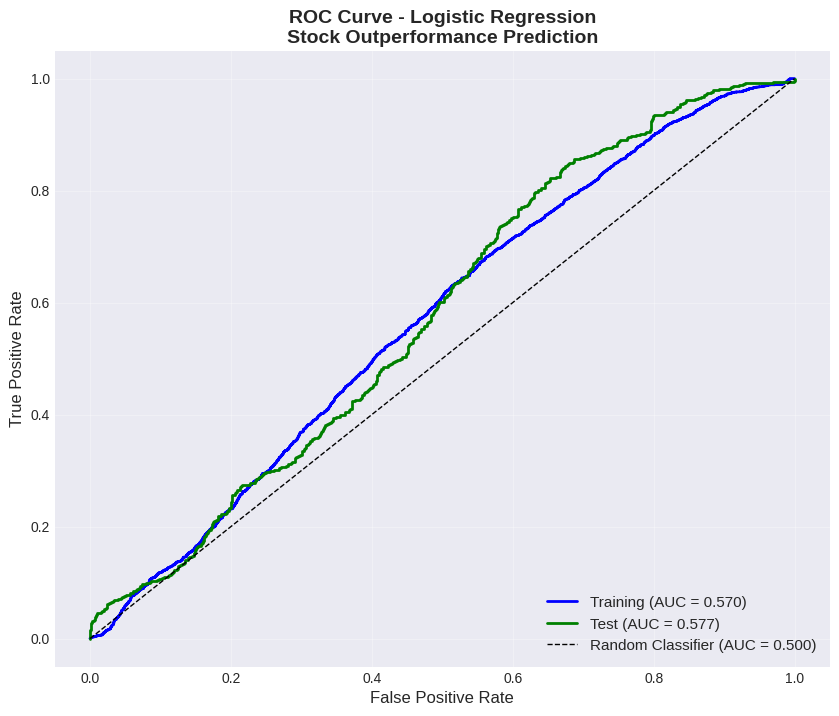

✓ ROC curve saved as 'roc_curve.png'

📊 ROC-AUC INTERPRETATION:
  ⚠️  Fair: AUC = 0.577 (Weak but better than random)


In [13]:
print("\n" + "="*60)
print("STEP 7: ROC Curve Analysis")
print("="*60)

# Calculate ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {train_auc:.3f})',
         linewidth=2, color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})',
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression\nStock Outperformance Prediction',
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curve saved as 'roc_curve.png'")

print("\n📊 ROC-AUC INTERPRETATION:")
if test_auc > 0.7:
    print(f"  ✓ Excellent: AUC = {test_auc:.3f} (Good predictive power)")
elif test_auc > 0.6:
    print(f"  ✓ Good: AUC = {test_auc:.3f} (Moderate predictive power)")
elif test_auc > 0.5:
    print(f"  ⚠️  Fair: AUC = {test_auc:.3f} (Weak but better than random)")
else:
    print(f"  ❌ Poor: AUC = {test_auc:.3f} (No better than random guessing)")

## Feature Importance Analysis


STEP 8: Feature Importance Analysis

📊 TOP 10 MOST IMPORTANT FEATURES:
27. sector_XLF_t              | Coef: +0.0681 | ↑ Increases outperformance probability
30. sector_XLI_t              | Coef: +0.0624 | ↑ Increases outperformance probability
13. volatility_ratio          | Coef: +0.0485 | ↑ Increases outperformance probability
 9. vol_z                     | Coef: -0.0359 | ↓ Decreases outperformance probability
 4. r_3M                      | Coef: -0.0232 | ↓ Decreases outperformance probability
15. FedFunds_t                | Coef: -0.0228 | ↓ Decreases outperformance probability
22. spy_SMA_200_t             | Coef: -0.0126 | ↓ Decreases outperformance probability
26. sector_XLK_t              | Coef: -0.0117 | ↓ Decreases outperformance probability
18. Put_Call_Ratio_t          | Coef: +0.0086 | ↑ Increases outperformance probability
14. VIX_t                     | Coef: +0.0086 | ↑ Increases outperformance probability

📊 TOP 10 FEATURES THAT INCREASE OUTPERFORMANCE (Positive 

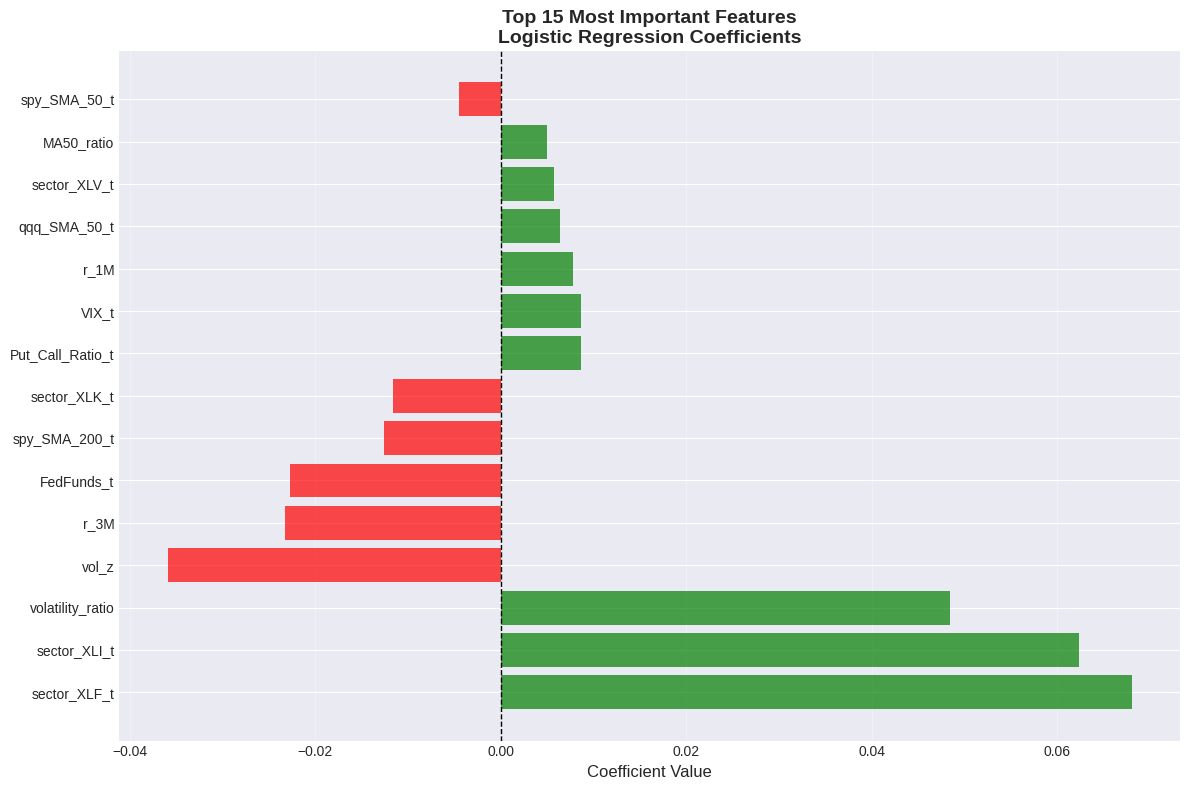


✓ Feature importance chart saved as 'feature_importance.png'
✓ Feature importance data saved as 'feature_importance.csv'


In [14]:
print("\n" + "="*60)
print("STEP 8: Feature Importance Analysis")
print("="*60)

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logistic_model.coef_[0],
    'Abs_Coefficient': np.abs(logistic_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n📊 TOP 10 MOST IMPORTANT FEATURES:")
print("="*60)
for i, row in coefficients.head(10).iterrows():
    direction = "↑ Increases" if row['Coefficient'] > 0 else "↓ Decreases"
    print(f"{i+1:2d}. {row['Feature']:25s} | Coef: {row['Coefficient']:+.4f} | {direction} outperformance probability")

print("\n📊 TOP 10 FEATURES THAT INCREASE OUTPERFORMANCE (Positive coefficients):")
positive_coefs = coefficients[coefficients['Coefficient'] > 0].head(10)
for i, row in positive_coefs.iterrows():
    print(f"  • {row['Feature']:25s} | Coef: {row['Coefficient']:+.4f}")

print("\n📊 TOP 10 FEATURES THAT DECREASE OUTPERFORMANCE (Negative coefficients):")
negative_coefs = coefficients[coefficients['Coefficient'] < 0].head(10)
for i, row in negative_coefs.iterrows():
    print(f"  • {row['Feature']:25s} | Coef: {row['Coefficient']:+.4f}")

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = coefficients.head(15)

colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Most Important Features\nLogistic Regression Coefficients',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance chart saved as 'feature_importance.png'")

# Save feature importance to CSV
coefficients.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance data saved as 'feature_importance.csv'")

## Generate Summary Report

In [15]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT: LOGISTIC REGRESSION MODEL")
print("="*80)

print(f"""
📊 DATASET SUMMARY:
  • Total observations: {len(df)}
  • Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)
  • Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)
  • Number of features: {X.shape[1]}
  • Target: Binary (0=Underperform, 1=Outperform S&P 500)

🎯 MODEL PERFORMANCE (TEST SET):
  • Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
  • Precision: {test_precision:.4f}
  • Recall: {test_recall:.4f}
  • F1-Score: {test_f1:.4f}
  • ROC-AUC: {test_auc:.4f}

📈 KEY INSIGHTS:
  • Training time: {training_time:.2f} seconds
  • Overfitting gap: {accuracy_diff*100:.2f}%
  • Top positive feature: {coefficients.iloc[0]['Feature']} ({coefficients.iloc[0]['Coefficient']:+.4f})
  • Model generalizes: {"✓ Yes" if accuracy_diff < 0.05 else "⚠️ Moderately" if accuracy_diff < 0.10 else "❌ Poor"}

💡 INTERPRETATION:
  The Logistic Regression model achieved {test_accuracy*100:.1f}% accuracy in predicting
  whether stocks will outperform the S&P 500. The most important predictive features
  were: {', '.join(coefficients.head(3)['Feature'].tolist())}.

  {'This baseline performance demonstrates that stock outperformance is predictable' if test_accuracy > 0.6 else 'The moderate performance suggests that additional features or more complex models may be needed'}
  to reliably forecast relative stock performance.

📁 SAVED FILES:
  ✓ confusion_matrices.png - Visual comparison of predictions
  ✓ roc_curve.png - Model discrimination ability
  ✓ feature_importance.png - Most influential features
  ✓ feature_importance.csv - Complete coefficient data
""")

print("="*80)
print("✅ LOGISTIC REGRESSION TRAINING COMPLETE!")
print("="*80)


FINAL SUMMARY REPORT: LOGISTIC REGRESSION MODEL

📊 DATASET SUMMARY:
  • Total observations: 8594
  • Training samples: 6875 (80.0%)
  • Test samples: 1719 (20.0%)
  • Number of features: 30
  • Target: Binary (0=Underperform, 1=Outperform S&P 500)

🎯 MODEL PERFORMANCE (TEST SET):
  • Accuracy: 0.5125 (51.25%)
  • Precision: 0.5806
  • Recall: 0.4280
  • F1-Score: 0.4927
  • ROC-AUC: 0.5768

📈 KEY INSIGHTS:
  • Training time: 4.77 seconds
  • Overfitting gap: 3.70%
  • Top positive feature: sector_XLF_t (+0.0681)
  • Model generalizes: ✓ Yes

💡 INTERPRETATION:
  The Logistic Regression model achieved 51.3% accuracy in predicting
  whether stocks will outperform the S&P 500. The most important predictive features
  were: sector_XLF_t, sector_XLI_t, volatility_ratio.
  
  The moderate performance suggests that additional features or more complex models may be needed
  to reliably forecast relative stock performance.

📁 SAVED FILES:
  ✓ confusion_matrices.png - Visual comparison of predic